In [1]:
%load_ext autoreload
%autoreload 2

from aion import AION

model = AION.from_pretrained('/mnt/ceph/users/polymathic/aion/dec24/base')
model = model.cuda().eval()

Loading weights from local directory


In [34]:
from mmoma.datasets.astropile import FastAstroPileLoader
from mmoma.datasets.preprocessing import (
    ClampImage,
    CropImage,
    RescaleToLegacySurvey,
    PadImageBands,
)
import matplotlib.pyplot as plt

dm = FastAstroPileLoader(
    dataset_path="/mnt/ceph/users/polymathic/MultimodalUniverse/legacysurvey",
    formatting_fns=[
        CropImage(96),
        ClampImage(),
        RescaleToLegacySurvey(),
        PadImageBands(version="oct24"),
    ],
    shuffle_buffer_size=100,
    batch_size=256,
    num_workers=10,
)
dm.setup("train")
loader = dm.train_dataloader()
batch = next(iter(loader))

In [35]:
# We shouldn't need to do this, but the model expects the image to be in a specific format
# and the dataloader doesn't do this for us
batch["image"]["array"] = batch["image"]["flux"]

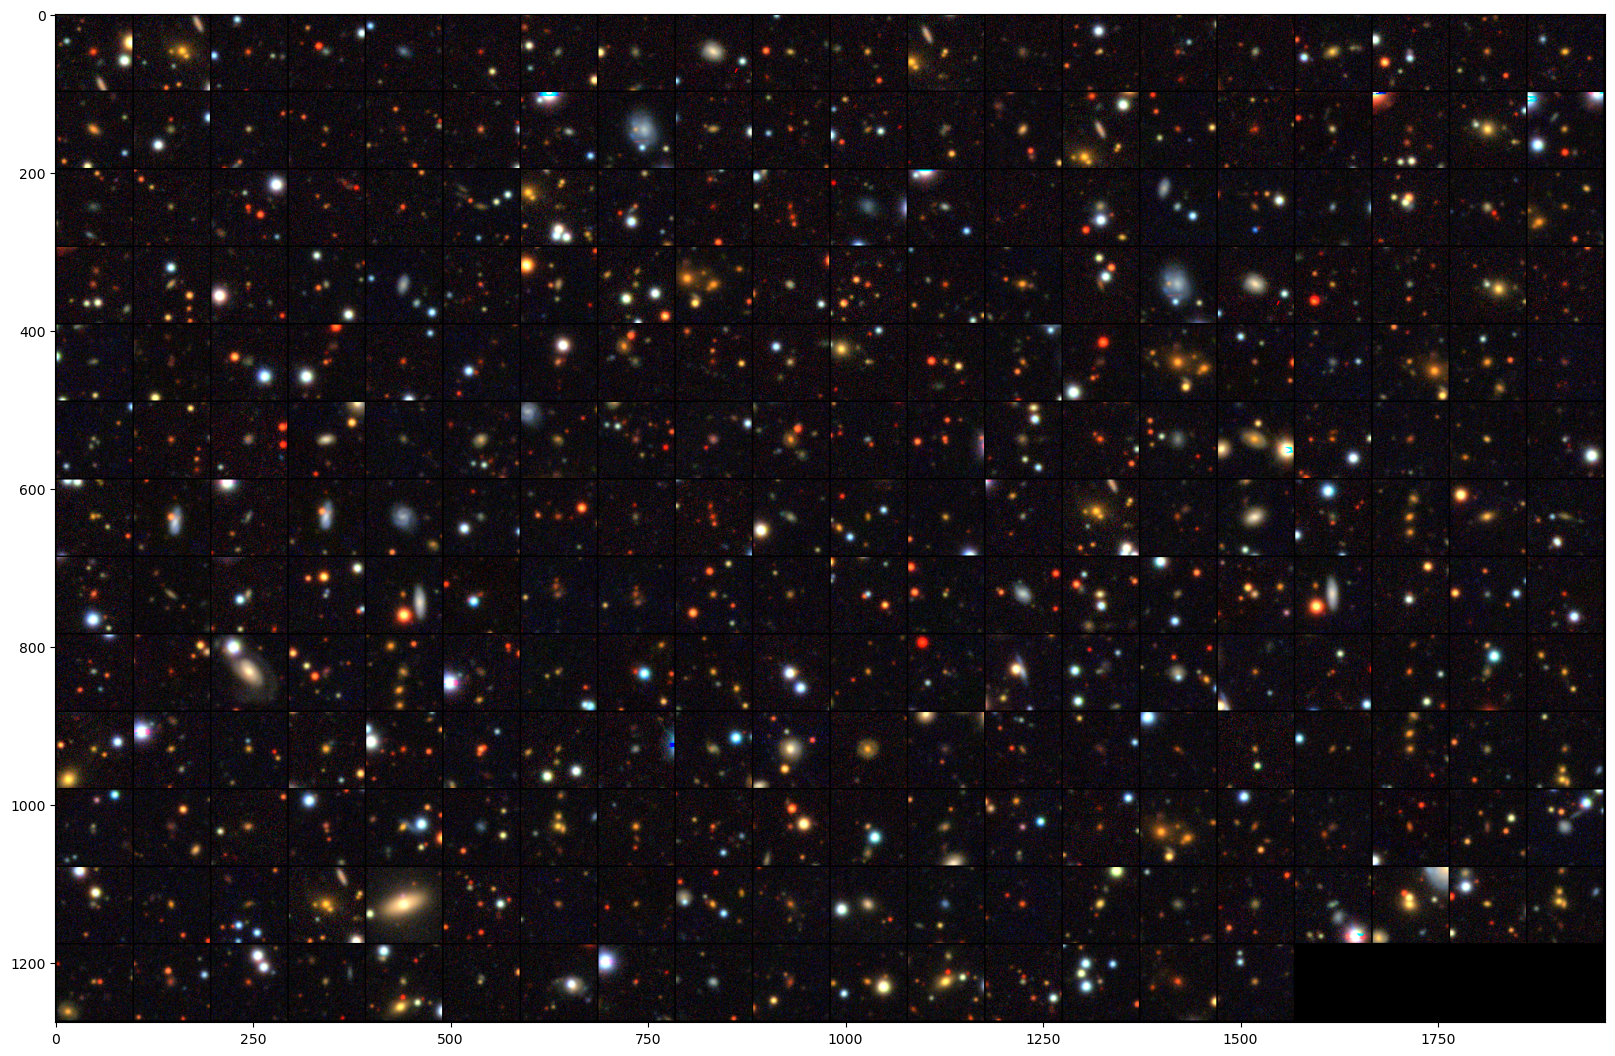

In [36]:
from torchvision.utils import make_grid
from mmoma.evaluation.image import decals_to_rgb

# We need to select the (5,6,8) channels to get the RGB image for the Legacy Survey (g,r,z)
images = decals_to_rgb(batch["image"]['array'][:,[5,6,8]], m=0.01)

plt.figure(figsize=(20, 20))
plt.imshow(make_grid(images, nrow=20).permute(1,2,0).cpu())

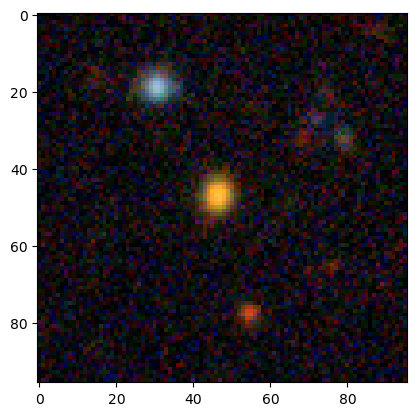

In [96]:
idx = 19
ground_truth = batch["image"]["array"][idx][[5,6,8],:,:].unsqueeze(0)
plt.imshow(decals_to_rgb(ground_truth, m=0.01).squeeze().T)

In [97]:
import os, sys
from collections.abc import Mapping, Sequence

import numpy as np
import torch
import yaml
from aion.tokenizers import load_tokenizer
from aion.utils import to

def get_tokenizers(survey, device="cuda"):
    """Loads all the tokenizers for the given survey"""
    # Loads the tokenizers configuration from the yaml file
    file_path = "tokenizers.yaml"
    print(file_path)
    with open(file_path, "r") as file:
        tokenizers = yaml.safe_load(file)
    outputs = {}
    for key, value in tokenizers[survey].items():
        outputs[key] = load_tokenizer(value, device)
    return outputs

tokenizers = get_tokenizers("legacysurvey")

tokenizers.yaml


<torch_package_39>.mmoma/third_party/rotary_embedding_torch/rotary_embedding_torch.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)
<torch_package_39>.mmoma/third_party/rotary_embedding_torch/rotary_embedding_torch.py:257: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)
<torch_package_40>.vector_quantize_pytorch/vector_quantize_pytorch.py:445: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)
<torch_package_40>.vector_quantize_pytorch/vector_quantize_pytorch.py:630: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)
<torch_package_40>.vector_quantize_pytorch/finite_scalar_quantiza

In [98]:
# do all the tokenization on the GPU
tokenized_sample = {}
hsc_keys = ["image", "FLUX_G", "FLUX_R", "FLUX_I", "FLUX_Z", "FLUX_W1", "FLUX_W2", "FLUX_W3", "FLUX_W4", "EBV", "SHAPE_R", "SHAPE_E1", "SHAPE_E2"]

with torch.no_grad():
    for key in hsc_keys:
        tokenized_sample[key] = tokenizers[key].encode({key: to(batch[f"{key}"],"cuda")})

tokenized_sample["image"].shape

torch.Size([256, 24, 24])

In [99]:
model.encoder_embeddings.keys()

odict_keys(['catalog', 'tok_a_g', 'tok_a_i', 'tok_a_r', 'tok_a_y', 'tok_a_z', 'tok_dec', 'tok_ebv', 'tok_flux_bp_gaia', 'tok_flux_g', 'tok_flux_g_gaia', 'tok_flux_i', 'tok_flux_r', 'tok_flux_rp_gaia', 'tok_flux_w1', 'tok_flux_w2', 'tok_flux_w3', 'tok_flux_w4', 'tok_flux_z', 'tok_image', 'tok_image_hsc', 'tok_mag_g', 'tok_mag_i', 'tok_mag_r', 'tok_mag_y', 'tok_mag_z', 'tok_parallax', 'tok_ra', 'tok_segmap', 'tok_shape11', 'tok_shape12', 'tok_shape22', 'tok_shape_e1', 'tok_shape_e2', 'tok_shape_r', 'tok_spectrum_desi', 'tok_spectrum_sdss', 'tok_xp_bp', 'tok_xp_rp', 'tok_z'])

In [100]:
tokenized_sample.keys()

dict_keys(['image', 'FLUX_G', 'FLUX_R', 'FLUX_I', 'FLUX_Z', 'FLUX_W1', 'FLUX_W2', 'FLUX_W3', 'FLUX_W4', 'EBV', 'SHAPE_R', 'SHAPE_E1', 'SHAPE_E2'])

In [101]:
batched_sample = {
    "tok_flux_g": tokenized_sample["FLUX_G"][idx],
    "tok_flux_r": tokenized_sample["FLUX_R"][idx],
    "tok_flux_i": tokenized_sample["FLUX_I"][idx],
    "tok_flux_z": tokenized_sample["FLUX_Z"][idx],
    "tok_flux_w1": tokenized_sample["FLUX_W1"][idx],
    "tok_flux_w2": tokenized_sample["FLUX_W2"][idx],
    "tok_flux_w3": tokenized_sample["FLUX_W3"][idx],
    "tok_flux_w4": tokenized_sample["FLUX_W4"][idx],
    "tok_ebv": tokenized_sample["EBV"][idx],
    "tok_shape_r": tokenized_sample["SHAPE_R"][idx],
    "tok_shape_e1": tokenized_sample["SHAPE_E1"][idx],
    "tok_shape_e2": tokenized_sample["SHAPE_E2"][idx],
    "tok_image": tokenized_sample["image"][idx].reshape(24*24),
}

In [102]:
from aion.fourm.generate import GenerationSampler, init_full_input_modality, init_empty_target_modality, build_chained_generation_schedules
from aion.fourm.modality_info import MODALITY_INFO

GLOBAL_TEMP = 0.7

# Set up the input to the sampler
input_to_sampler = {}
for k in batched_sample.keys():
    v = batched_sample[k]
    input_to_sampler[k] = {
        "tensor": v.cuda().unsqueeze(0).unsqueeze(-1),
        "input_mask": torch.zeros_like(v, dtype=torch.bool, device="cuda").unsqueeze(0).unsqueeze(-1),
        "target_mask": torch.ones_like(v, dtype=torch.bool, device="cuda").unsqueeze(0).unsqueeze(-1),
    }

# Set up targets
input_mod = ['tok_flux_g', 'tok_flux_r', 'tok_flux_i', 'tok_flux_z', 'tok_flux_w1', 'tok_flux_w2', 'tok_flux_w3', 'tok_flux_w4', 'tok_ebv', 'tok_shape_r', 'tok_shape_e1', 'tok_shape_e2']
target_mod = ['tok_image']
tokens_per_target = [24*24]

# Initialize input modalities
for im in input_mod:
    input_to_sampler = init_full_input_modality(input_to_sampler, MODALITY_INFO, im, 'cuda')

for tm, ntoks in zip(target_mod, tokens_per_target):
    input_to_sampler = init_empty_target_modality(input_to_sampler, MODALITY_INFO, tm, input_to_sampler[tm]['tensor'].shape[0], ntoks, 'cuda')

sampler = GenerationSampler(model)

autoregression_schemes = ['roar']*len(input_mod)
token_decoding_schedules = ['linear']*len(input_mod)
decoding_steps = [25]*len(input_mod)
temps = [GLOBAL_TEMP]*len(input_mod)
temp_schedules = ['constant']*len(input_mod)
cfgs_scales = [1.0]*len(input_mod)
cfg_schedules = ['constant']*len(input_mod)

schedule = build_chained_generation_schedules(
    cond_domains=input_mod, 
    target_domains=target_mod, 
    tokens_per_target=tokens_per_target,     
    autoregression_schemes=autoregression_schemes,
    decoding_steps=decoding_steps,
    token_decoding_schedules=token_decoding_schedules, 
    temps=temps,
    temp_schedules=temp_schedules,
    cfg_scales=cfgs_scales,
    cfg_schedules=cfg_schedules,
)

n_samples = 5
output_samples = torch.stack([sampler.generate(input_to_sampler, schedule, verbose=True)['tok_image']['tensor'] for _ in range(n_samples)]).reshape(n_samples, 24, 24)

25it [00:00, 41.17it/s]
25it [00:00, 42.40it/s]
25it [00:00, 42.38it/s]
25it [00:00, 41.99it/s]
25it [00:00, 42.61it/s]


In [103]:
with torch.no_grad():
    generated_images = tokenizers['image'].decode(output_samples, {"image": {'band': ['DES_G', 'DES_R', 'DES_I', 'DES_Z'], 'channel_mask': torch.ones(5,9).to('cuda')}})['image']['array'].detach().cpu()

generated_images = decals_to_rgb(generated_images[:,[5,6,8],:,:], m=0.01)

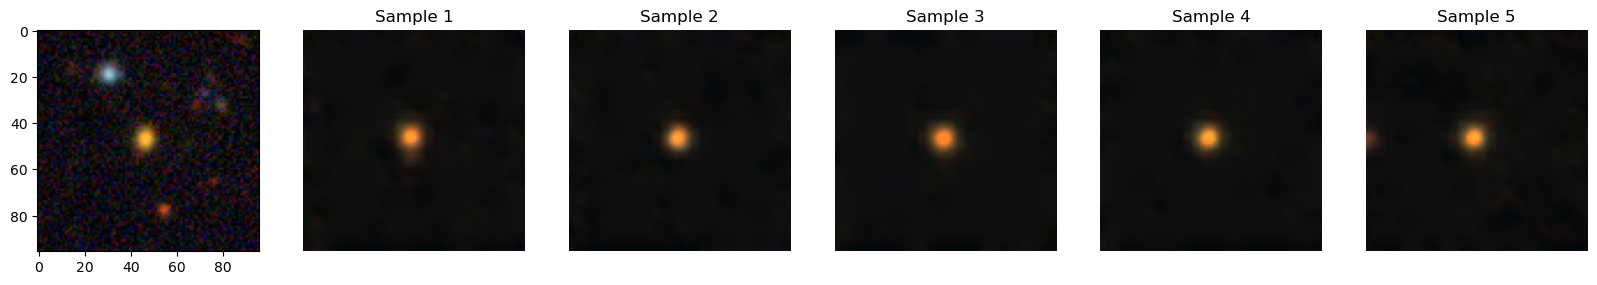

In [104]:
fig, ax = plt.subplots(1, n_samples+1, figsize=(20, 20))

ax[0].imshow(decals_to_rgb(ground_truth, m=0.01).squeeze().T)

for i in range(n_samples):
    ax[i+1].imshow(generated_images[i].squeeze().T)
    ax[i+1].set_title(f"Sample {i+1}")
    ax[i+1].axis('off')